# Plan:

- ~~Извлекать статьи по ключевым словам;~~
- ~~Суммаризировать каждую статью;~~
- Суммаризация подходов из статей;
- Рерайтинг запроса;
- Статья в виде json;
- Выбор подходящей LLM; (https://ollama.com/library/llama3.2)
- Разработка веб-интерфейса;
- *Попробовать RAPTOR для суммаризации (https://arxiv.org/html/2401.18059v1);

Для работы с Ollama - https://github.com/ollama/ollama

Гайд по разработке ReAct Агента - https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/#create-react-agent

# LangGraph ReAct agent tutorial

## Build agent

In [1]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_community.retrievers.arxiv import ArxivRetriever

import json
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage
from langchain_core.runnables import RunnableConfig

from langchain_core.language_models import BaseChatModel
from langchain.tools import BaseTool


from pydantic import BaseModel, Field
from langchain_community.utilities.arxiv import ArxivAPIWrapper
import arxiv
import fitz

class AgentState(TypedDict):
    """The state of the agent"""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    model: BaseChatModel
    # tools: Sequence[BaseTool]

    

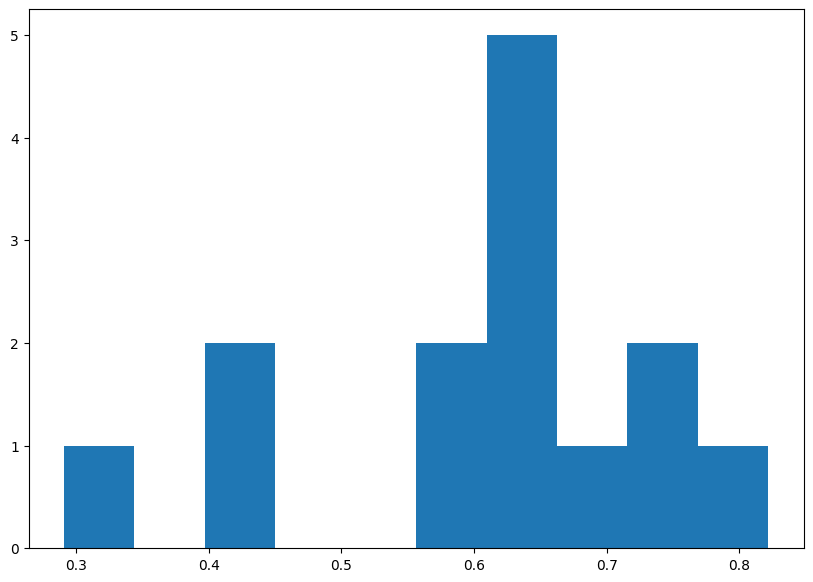

In [12]:
import os
import sys
sys.path.append('../')

from matplotlib import pyplot as plt
from score import TextsSimilarity

folders = os.listdir('../data')
metric = TextsSimilarity()
scores = []

for n in range(len(folders)):
# n = 2
    folder_name = folders[n]
    with open(os.path.join("../data", folder_name, "ans.txt"), "r") as f:
        ans = ""
        for text in f.readlines():
            ans += text
    with open(os.path.join("../data", folder_name, "rw.txt"), "r") as f:
        ref = ""
        for text in f.readlines():
            ref += text
            
    scores.append(metric(ans, ref)[0])

plt.figure(figsize=(10, 7))
plt.hist(x=scores); 

In [13]:
[(name, metric) for name, metric in zip(folders, scores)]

[('selfattn_with_rel_repr', 0.6465778),
 ('roberta', 0.4468929),
 ('attention_is_all_you_need', 0.67950094),
 ('COSMIC', 0.40350688),
 ('layernorm', 0.7460119),
 ('T2T_for_NMT', 0.82187605),
 ('craft', 0.65621465),
 ('bahdanau_attn', 0.71698546),
 ('luong_attn', 0.6117296),
 ('sensorscan', 0.2907752),
 ('RAPTOR', 0.6253125),
 ('albert', 0.64190036),
 ('kovalenko_graph', 0.56014025),
 ('BERT', 0.5679616)]

In [14]:
import numpy as np
np.mean(scores)

0.601099

In [ ]:
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

model = ChatOllama(model="llama3.2:3b", num_ctx=32768) # 65536
# model1 = ChatOllama(model="llama3.2:3b", num_ctx=32768)

# Инструмент поиска на Arxiv
# @tool("ArxivSearch") # попробовать ArxivRetriever
# def arxiv_search_tool(query: str, max_results: int = 2):
#     """Search articles on Arxiv by keywords"""
#     search = arxiv.Search(
#         query=query,
#         max_results=max_results,
#         sort_by=arxiv.SortCriterion.Relevance
#     )
#     articles = []
#     for result in search.results():
#         articles.append({
#             "title": result.title,
#             "summary": result.summary,
#             "url": result.entry_id
#         })
#     return articles

# @tool("ArxivSearch")
# def arxiv_search_tool(query: str, max_results: int = 2):
#     """Search articles on Arxiv by keywords"""
#     retriever = ArxivRetriever(load_max_docs=max_results, get_full_documents=True)
#     docs = retriever.invoke(query)
#     fmt_articles = [f"Title: {d.metadata['Title']} \n Content: {d.page_content}" for d in docs]

#     return "\n\n".join(fmt_articles)

@tool("ArticleSummarizingTool")
def arxiv_search_tool(query: str, max_results: int = 2):
    """Search articles on Arxiv by keywords and returns summaries of each article.
    It takes keywords as query, max count of requested articles and model from AgentState"""
    retriever = ArxivRetriever(
        load_max_docs=min(1, max_results), 
        get_full_documents=True, 
        doc_content_chars_max=None,
    )

    docs = retriever.invoke(query)

    sys_prompt = SystemMessage(
        """You are a helpful summarization AI assistant that takes text of Arxiv article and summarizes it into general overview including the most important points.
        The max summarization length is 1000 characters. Minimum summarization length is 200 characters. 
        Do not return anything except summary."""
    )
    summary = "Summaries:"

    # print("query: ", query, "num docs:", len(docs))
    for i, doc in enumerate(docs):
        inp = [sys_prompt] + [HumanMessage(doc.page_content)]
        sum_i = f"{doc.metadata['Title']} \n {model.invoke(inp).content}"
        summary += "\n\n" + sum_i
    
    return summary

@tool("SummarizingTool") # name="summarize_tool", description="Summarizes text using a language model"
def summarize_tool(text: str):
    """Summarizes text using a language model"""
    prompt = f"Summarize the following article: {text}"
    summary = model(prompt)
    return summary

# Инструмент суммаризации текста
# @tool("SummarizingTool") # name="summarize_tool", description="Summarizes text using a language model"
# def summarize_tool(text: str):
#     """Summarizes article's content into a general overview of the approaches"""
#     prompt = f"Summarize the following content into a general overview of the approaches: {text}"
#     summary = model.invoke(prompt)
#     return summary


tools = [arxiv_search_tool, summarize_tool]
model_with_tools = model.bind_tools(tools)

In [ ]:
tools_by_name = {tool.name: tool for tool in tools}

def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
        state: AgentState,
        config: RunnableConfig,
):
    system_prompt = SystemMessage(
         """You are a helpful AI assistant that takes a user input and summarize arxiv articles found by strictly keywords from input. 
        You can use tool you have for searching articles and summarizing them.
        You need to summarize approaches from all found articles and make general overview of the approaches
        When you are certain you've got enough article summaries comprise them into related work with references.
        Respond with plain text, do not include enumerates and any other paragraphs beside Related Work."""
        )
    response = model_with_tools.invoke([system_prompt] + state["messages"], config)
    return {"messages": response}

def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    

In [14]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

workflow.add_edge("tools", "agent")

graph = workflow.compile()


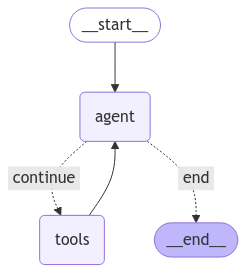

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use agent

In [16]:
# def print_stream(stream):
#     for s in stream:
#         message = s["messages"][-1]
#         if isinstance(message, BaseMessage):
#             print(f"=================== {message.__class__.__name__} ===================")
#         else:
#             message.pretty_print()
#         print(message.content)

def print_stream(stream):
    idx = 0
    for s in stream:
        for message in s["messages"][idx:]:
            idx += 1
            if isinstance(message, tuple):
                print(message)
            else:
                message.pretty_print()


inputs = {"messages": [("user", "attention")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

attention
================================== Ai Message ==================================
Tool Calls:
  ArticleSummarizingTool (863046ea-86ac-44c7-b70d-0a0d576cb4ce)
 Call ID: 863046ea-86ac-44c7-b70d-0a0d576cb4ce
  Args:
    max_results: 10
    model: 
    query: attention
    state: {'AgentState': {'model': 'transformer'}}
================================= Tool Message =================================
Name: ArticleSummarizingTool

"Summaries:\n\nExploring Human-like Attention Supervision in Visual Question Answering \n \n\nAgent Attention: On the Integration of Softmax and Linear Attention \n \n\nTri-Attention: Explicit Context-Aware Attention Mechanism for Natural Language Processing \n "
================================== Ai Message ==================================

Here is a summary of the articles found:

The article "Exploring Human-like Attention Supervision in Visual Question Answering" discus

In [17]:
# rtr = ArxivRetriever(load_max_docs=2, get_full_documents=True, doc_content_chars_max=None)

# docs = rtr.invoke("attention")

# docs[0]

In [18]:
model.invoke("Hello! How are you?")

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-12-15T18:43:19.6219702Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2623486200, 'load_duration': 18214800, 'prompt_eval_count': 245, 'prompt_eval_duration': 381000000, 'eval_count': 30, 'eval_duration': 2223000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='ArticleSummarizingTool', arguments={'max_results': '10', 'model': '', 'query': ''}))])}, id='run-4490a280-d1bf-48ba-86db-1c8f9b71e2be-0', tool_calls=[{'name': 'ArticleSummarizingTool', 'args': {'max_results': '10', 'model': '', 'query': ''}, 'id': '9121c349-01b5-48fb-92b0-0bfa7793d98f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 245, 'output_tokens': 30, 'total_tokens': 275})

In [19]:
# print(docs[0].page_content)

In [20]:
# wrapper = ArxivAPIWrapper(
#     top_k_results=3,
#     load_max_docs=3,
#     doc_content_chars_max = None,
# )
# docs = wrapper.get_summaries_as_docs(query="attention")
# docs[0]